<a href="https://colab.research.google.com/github/aminhm00/Deep-Face-Signature/blob/main/face_recognition_one_shot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf


import keras
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, Input
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l1,l2
from keras import backend as K
from keras.losses import binary_crossentropy,categorical_crossentropy


from keras.layers import Lambda

import matplotlib.pyplot as plt

In [5]:
import cv2 

In [3]:
input_shape = (112,92,1)
left = Input(input_shape)
right = Input(input_shape)

In [6]:
model = Sequential()

model.add(Conv2D(64,kernel_size=(20,20),input_shape=input_shape,padding='same',kernel_regularizer=l2(2e-5)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2,2),strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.50))

model.add(Conv2D(64,kernel_size=(15,15),padding='same',kernel_regularizer=l2(2e-3)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2,2),strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.40))

model.add(Conv2D(128,kernel_size=(10,10),padding='same',kernel_regularizer=l2(2e-3)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2,2),strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.30))

model.add(Conv2D(128,kernel_size=(7,7),padding='same',kernel_regularizer=l2(1e-3)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2,2),strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256,kernel_size=(7,7),padding='same',kernel_regularizer=l2(1e-3)))
model.add(LeakyReLU(alpha=0.3))
model.add(MaxPooling2D((2,2),strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(18432//6,activation='sigmoid',kernel_regularizer=l2(1e-3)))

left_output = model(left)
right_output = model(right)

layer_lambda_2 = Lambda(lambda inputs:K.abs(inputs[0]-inputs[1]))

layer_second_last = layer_lambda_2([left_output,right_output])


out = Dense(1,activation='sigmoid')(layer_second_last)

network = Model(inputs=[left,right],outputs=out)

print(model.summary(),network.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 92, 64)       25664     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 112, 92, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 46, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 46, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 56, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 46, 64)        921664    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 46, 64)        0

In [27]:
optimizer = Adam(0.00006)
network.compile(loss= "binary_crossentropy",optimizer=optimizer)

In [7]:
import os
def loading(path,n=0):
    X=[]
    y=[]
    person_dict = {}
    curr_y = n
    for person in os.listdir(path):
        print('loading person', person)
        person_dict[person]= [curr_y,None]
        face_path = os.path.join(path,person)
        category_images = []
        for filename in os.listdir(face_path):
            image_path = os.path.join(face_path,filename)
            image = plt.imread(image_path)
            category_images.append(image)
            y.append(curr_y)
        try:
            X.append(np.stack(category_images))
        except ValueError as e:
            print(e)
        curr_y +=1
        person_dict[person][1] = curr_y - 1
    y = np.vstack(y)
    X = np.stack(X)
    return X,y,person_dict

In [ ]:
!unzip validation.zip
!unzip train.zip

In [ ]:
!unzip amin.zip

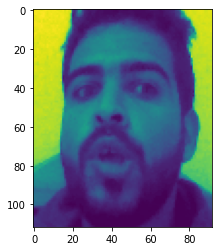

In [13]:
img1 = cv2.imread('amin/22.jpg')
img1= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1= cv2.resize(img1,(92,112))
img2 = cv2.imread('amin/10.jpg')
img2= cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
img2= cv2.resize(img2,(92,112))
plt.imshow(img1)

In [ ]:
Xtrain,ytrain,person_dict = loading("train")
Xval,yval,person_dict_val = loading("validation")

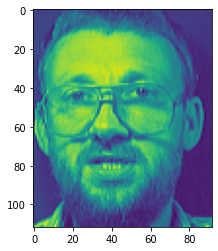

In [16]:
plt.imshow(Xtrain[0,1])

In [17]:
import numpy.random as rng
def get_batch(batch_size,s="train"):
    
    if s == "train":
        X= Xtrain
        categories = person_dict
    else:
        X= Xval
        categories = None
    
    n_classes, n_examples, w, h = X.shape
    
    #randomly samples several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    #initialize 2 empty array for the input image batch
    paires = [np.zeros((batch_size,w,h,1)) for i in range(2)]
    
    targets = np.zeros((batch_size,))
    
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        n_person = categories[i]
        index1 = rng.randint(0,n_examples)
        paires[0][i,:,:,:] = X[n_person,index1].reshape(w,h,1)
        index2 = rng.randint(0,n_examples)
        
        if (i >= batch_size//2):
            n_person2 = n_person
        else:
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            n_person2 = (n_person + rng.randint(1,n_classes)) % n_classes
        paires[1][i,:,:,:] = X[n_person2,index2].reshape(w,h,1)
        
    return paires , targets
        

In [18]:
def generate(batch_size,s="train"):
    while True:
        paires, targets = get_batch(batch_size,s)
        yield (paires, targets)

In [20]:
from sklearn.utils import shuffle

def make_oneshot_task(N, s="val"):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = Xtrain
        categories = person_dict
    else:
        X = Xval
        categories = person_dict_val
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))

    categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [21]:
def test_oneshot(model, N, k, s = "val", verbose = 0):
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct

In [24]:
evaluate_every = 2000 # interval for evaluating on one-shot tasks
batch_size = 25
n_iter = 10000 # No. of training iterations
N_way = 10 # how many classes for testing one-shot tasks
n_val = 10 # how many one-shot tasks to validate on
best = -1

In [25]:
model_path = './weights2/'

In [29]:
import time

print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = network.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test_oneshot(network, N_way, n_val, verbose=True)
        network.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 2000 iterations: 4.352710747718811 mins
Train Loss: 0.8701221942901611
Evaluating model on 10 random 10 way one-shot learning tasks ... 

Got an average of 60.0% 10 way one-shot learning accuracy 

Current best: 60.0, previous best: -1

 ------------- 

Time for 4000 iterations: 8.77613373597463 mins
Train Loss: 0.30176788568496704
Evaluating model on 10 random 10 way one-shot learning tasks ... 

Got an average of 80.0% 10 way one-shot learning accuracy 

Current best: 80.0, previous best: 60.0

 ------------- 

Time for 6000 iterations: 13.185865441958109 mins
Train Loss: 0.1306791752576828
Evaluating model on 10 random 10 way one-shot learning tasks ... 

Got an average of 40.0% 10 way one-shot learning accuracy 


 ------------- 

Time for 8000 iterations: 17.59900724887848 mins
Train Loss: 0.08191046118736267
Evaluating model on 10 random 10 way one-shot learning tasks ... 

Got an average 

In [ ]:
#w=network.load_weights(os.path.join(model_path, "weights.950.h5"))

In [30]:
ways = np.arange(1,10)
val_accs, train_accs = [], []
for N in ways:    
    val_accs.append(test_oneshot(network, N, 20, "val", verbose=True))
    train_accs.append(test_oneshot(network, N, 20, "train", verbose=True))

Evaluating model on 20 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 20 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 85.0% 2 way one-shot learning accuracy 

Evaluating model on 20 random 2 way one-shot learning tasks ... 

Got an average of 100.0% 2 way one-shot learning accuracy 

Evaluating model on 20 random 3 way one-shot learning tasks ... 

Got an average of 85.0% 3 way one-shot learning accuracy 

Evaluating model on 20 random 3 way one-shot learning tasks ... 

Got an average of 100.0% 3 way one-shot learning accuracy 

Evaluating model on 20 random 4 way one-shot learning tasks ... 

Got an average of 85.0% 4 way one-shot learning accuracy 

Evaluating model on 20 random 4 way one-shot learning tasks ... 

Got an average of 100.0% 4 way one-shot learning accura

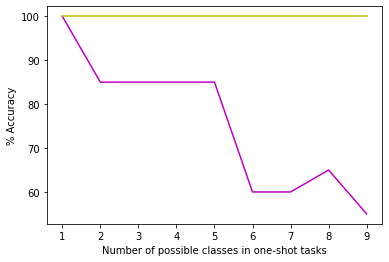

In [31]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.show()

In [23]:
network.load_weights("./weights.950.h5")

In [31]:
Xval.shape

(10, 10, 112, 92)

Text(0, 200, 'test2: low proba')

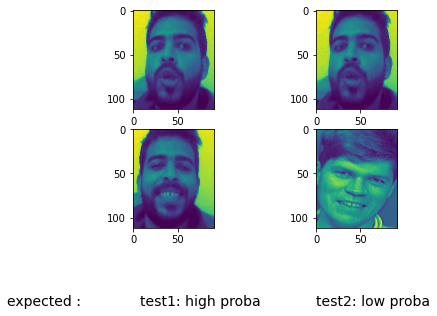

In [41]:

s1 = img1#Xval[0,1]
s2 = img2#[0,4]
s3 = Xval[7,1]

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(s1)
axarr[0,1].imshow(s1)
axarr[1,0].imshow(s2)
axarr[1,1].imshow(s3)
plt.text( -350,200,"expected :", fontsize=14)
plt.text( -200,200,"test1: {}".format("high proba"), fontsize=14)
plt.text(0,200,"test2: {}".format("low proba"), fontsize=14)


In [39]:
w = Xtrain.shape[2]
h = Xtrain.shape[3]
S1 = s1.reshape((w,h,1))
S2 = s2.reshape((w,h,1))
S3 = s3.reshape((w,h,1))
p1,p2 =network.predict([ np.array([S1,S1]) , np.array([S2,S3]) ])

Text(0, 200, 'test2: [0.03153671]')

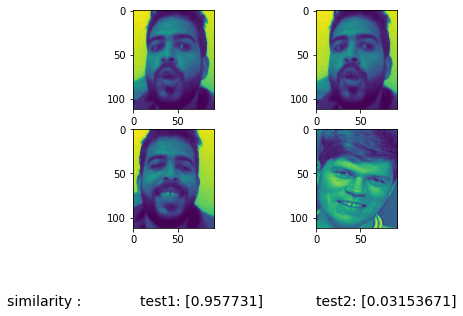

In [40]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(s1)
axarr[0,1].imshow(s1)
axarr[1,0].imshow(s2)
axarr[1,1].imshow(s3)
plt.text( -350,200,"similarity :", fontsize=14)
plt.text( -200,200,"test1: {}".format(p1), fontsize=14)
plt.text(0,200,"test2: {}".format(p2), fontsize=14)

# Nouvelle section